# Notebook: Use NN to predict disease from chemicals using Opa2Vec vectors
<b> Author: </b> Ian Coleman <br>
<b> Purpose: </b> Take the vectors created in the opa2vec notebook. This took chemical go functions
    and disease go function, creating vectors for each. Train a NN to predict positive chem-dis relationships from these vectors

In [173]:
## TODO
# Hyperparameter tuning:
# 1. How many uncorrelated pairs do we want
# 2. Epochs
# 3. Batch size
# 4. Number of layers, number of nodes per layer
# 5. Activation functions

In [174]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randint
import random
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from pandas_ml import ConfusionMatrix
import json
import subprocess
import pickle

#Set random seed
np.random.seed(1606)

### 1. Import Vectors and Pre-Process them

In [175]:
# Import vec file
with open('go-gofuncs.lst', 'r') as file:
    text = file.read()

In [176]:
# Strip and split vector data into list of lists [chem, vec]
text = text.replace('\n', '')
text = text.split(']')
text = [item.strip().split(' [') for item in text]

# Turn it into a data frame
df = pd.DataFrame(text)
df.columns = ['ID', 'Vector']

# Clean
df = df.dropna()
df['Vector'] = df.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# Turn vector column into a list
df['Vector'] = df.Vector.map(lambda x: x.split(','))

In [177]:
df.head()

,ID,Vector
0,MESH:D012559,"[1.76247600e-02, -1.05403718e-02, -4.61959302e..."
1,MESH:D009404,"[0.01795662, 0.13640046, 0.03051887, -0.100085..."
2,MESH:D001749,"[-8.68742093e-02, 8.83234814e-02, -2.54237115e..."
3,MESH:D011471,"[-0.00926186, 0.04098112, -0.4911138, -0.22025..."
4,MESH:D008106,"[-0.12722802, 0.07976454, -0.5775048, -0.28237..."


### 2. Create DF for NN
Munge the df into the following columns:<br>
ChemID DisID ChemVec DisVec PositiveAssociationExists(binary)

In [178]:
# Step 1: Import file of proven chem-dis positive associations (created in ctd-to-nt notebook from ctd data)
chem_dis = pd.read_csv('../ctd-to-nt/chem-dis-pos-assocs.csv')
chem_dis.head()

,ChemicalID,DiseaseID
0,C112297,MESH:D006948
1,C112297,MESH:D012640
2,C425777,MESH:D006948
3,C013567,MESH:D006333
4,C418863,MESH:D013262


In [179]:
# Get rid of any chems/diseases that don't have a vector
chem_dis['DiseaseID'] = chem_dis['DiseaseID'].astype(str)
df['ID'] = df['ID'].astype(str)
id_list = df.ID.tolist() # list of chems+diseases with vecs

chem_dis['hasDVec'] = chem_dis.DiseaseID.map(lambda x: x in id_list)
chem_dis['hasCVec'] = chem_dis.ChemicalID.map(lambda x: x in id_list)
chem_dis = chem_dis.loc[(chem_dis['hasDVec'] == True) & (chem_dis['hasCVec'] == True)]
chem_dis = chem_dis.drop(['hasDVec','hasCVec'], axis=1)

In [180]:
# merge all info into one df
# this df now contains only correlated diseases and vecs
df_d = df.copy()
df_d.columns= ['DiseaseID', 'DVec']
df_c = df.copy()
df_c.columns= ['ChemicalID', 'CVec']
df1 = pd.merge(chem_dis, df_d, on='DiseaseID')
df1 = pd.merge(df1, df_c, on='ChemicalID')

df1['Correlation'] = 1 # currently only have correlated in there

In [181]:
df1.head()

,ChemicalID,DiseaseID,DVec,CVec,Correlation
0,C028474,MESH:D006528,"[-0.08689959, 0.06080057, -0.04620415, -0.1237...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1
1,C028474,MESH:D005355,"[-4.32693306e-03, 1.35906458e-01, -1.91942360e...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1
2,C028474,MESH:D006529,"[-0.02542116, 0.0981225, -0.01938446, -0.14929...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1
3,C028474,MESH:D006965,"[-0.01135238, 0.143319, 0.04601676, -0.1474806...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1
4,C028474,MESH:D008114,"[-0.10265561, 0.03210206, -0.13152453, -0.0728...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1


In [182]:
len(id_list)

3137

In [183]:
chem_dis.shape

(8651, 2)

In [184]:
# Create separate dfs of dis-vecs and chem-vecs ( in order to generate additional rows for df1)
dis = df.ID.map(lambda x: ('MESH' in x) | ('OMIM' in x))
chems = df.ID.map(lambda x: ('MESH' not in x) & ('OMIM' not in x))

df_chems = df[chems]
df_dis = df[dis]
df_chems = df_chems.reset_index(drop=True)
df_dis = df_dis.reset_index(drop=True)

In [185]:
# Add unrelated pairs to df1
no_rows = (df1.shape[0]-1)  # This is a parameter to be tuned --> how many uncorrelated pairs do we want
print('shape: ', no_rows)

# Randomly select chems and diseases (as many as there are related pairs)
no_chems = len(df_chems) -1
no_dis = len(df_dis) -1
rand_chems = np.random.choice(no_chems, no_rows, replace=True)
rand_dis = np.random.choice(no_dis, no_rows, replace=True)

# Add the new pairs as rows
for x in range(0, no_rows):
    int1 = rand_chems[x]
    int2 = rand_dis[x]
    chem, chemvec = df_chems.loc[int1, 'ID'], df_chems.loc[int1, 'Vector']
    dis, disvec = df_dis.loc[int2, 'ID'], df_dis.loc[int2, 'Vector']
    df1 = df1.append({'ChemicalID':chem, 'DiseaseID':dis, 'CVec':chemvec, 'DVec':disvec, 'Correlation':0}, ignore_index=True)

print(df1.shape)
# Drop any duplicates (removes known correlated pairs accidentally generated as uncorrelated)
df1 = df1.drop_duplicates(subset=['ChemicalID', 'DiseaseID'], keep=False)
print(df1.shape)

shape:  8650
(17301, 5)
(17145, 5)


In [186]:
# Convert the elements of the vectors to actual numbers
df1['DVec'] = df1.DVec.map(lambda x: [float(i) for i in x])
df1['CVec'] = df1.CVec.map(lambda x: [float(i) for i in x])

### Add Phenotypes
Got a list of Chem-Phenotypes from Sara Alth, where did these come from originally?
They have CID identifiers (Pubchem). Need to convert CTD ID to CID ID
Use API like so 
http://pubchem.ncbi.nlm.nih.gov/rest/pug/substance/sourceid/Comparative%20Toxicogenomics%20Database/C533207/cids/TXT/

In [187]:
## First we'll add DOIDs for diseases and CIDs for chemicals as an intermediate for adding phenotypes
# Read in CSV mapping chems to CID and dis to DOID
mapper = pd.read_csv('entities.lst')

# Make the maps from this
dis_map = dict(zip(mapper.ID, mapper.DOID))
chem_map = dict(zip(mapper.ID, mapper.CID))

# Apply the maps to df1
df1['DOID'] = df1.DiseaseID.map(lambda x: dis_map.get(x))
df1['CID'] = df1.ChemicalID.map(lambda x: chem_map.get(x))

In [242]:
df1.sample(3)

,ChemicalID,DiseaseID,DVec,CVec,Correlation,DOID,CID
4322,C030984,MESH:D000013,"[0.02198205, 0.11417542, 0.04393276, -0.125280...","[0.00182923221, 0.0916977972, 0.0454749316, -0...",1,NaN,CID100031423
10031,D012906,MESH:C562492,"[-0.00950537622, 0.0605401844, -0.0353811011, ...","[0.0206648111, 0.132286429, 0.00329295755, -0....",0,DOID_0060254,NaN
4746,D015215,MESH:D009461,"[0.0283588376, 0.118484624, 0.050269682, -0.10...","[-0.0648025498, 0.0389944874, -0.490757853, -0...",1,NaN,CID100035370


In [202]:
# Read in the association files from Sara
dis_phens = pd.read_csv('Disease-PhenotypeAssocation.txt', sep=' ', names=['DOID', 'Phenotype'])
chem_phens =  pd.read_csv('Drug-PhenotypeAssocation.txt', sep=' ', names=['CID', 'Phenotype'])

In [192]:
# The association files have a different format for each ID system than mine, homogenise these
# first chem
def cid_standardiser (cid):
    # Must be format CID + 9 int chars, starting with 1 seemingly
    cid = int(cid)
    output = 'CID1' + '0' * (8 - len(str(cid))) + str(cid)
    return output

df1['CID'] = df1.CID.map(lambda x: np.nan if math.isnan(x) else cid_standardiser(x))

In [193]:
# and now disease 
def doid_standardiser (doid):
    # Must be format DOID_ + ...
    # I'm unsure about how well this is working so print out the DOIDs that don't match
    doid = doid.replace(':', '_')
#     output = 'CID1' + '0' * (8 - len(str(cid))) + str(cid)
    return doid

df1['DOID'] = df1.DOID.map(lambda x: np.nan if isinstance(x, float) else doid_standardiser(x))

In [194]:
## Now that the DOIDs and CIDs are theoretically standardised we can chuck in the phens to df1

# First though check which DOIDs and CIDs do not match up --> SEEMS OK
# test_doids = df1[df1.DOID.map(lambda x: isinstance(x, str))].DOID.tolist()
# imported_doids = dis_phens.DOID.tolist()
# for item in test_doids:
#     if item not in imported_doids:
#         print(item)                            

### IAN!!! The below is dumb, forces max one phen per entity

In [195]:
# # Map DOIDs and CIDs to phens
# dis_map = dict(zip(dis_phens.DOID, dis_phens.Phenotype))
# chem_map = dict(zip(chem_phens.CID, chem_phens.Phenotype))

# df1['chemPhen'] = df1.CID.map(lambda x: chem_map.get(x, np.nan))
# df1['disPhen'] = df1.DOID.map(lambda x: dis_map.get(x, np.nan))

In [196]:
# df1.sample(2)

In [197]:
## Instead of the above two silly cells, just take the existing association files, opa2vec them and then integrate

In [171]:
# hp_dis = dis_phens['']

In [203]:
chem_phens.sample(3)

,CID,Phenotype
33035,CID100003826,<http://purl.obolibrary.org/obo/HP_0000969>
78939,CID100064929,<http://purl.obolibrary.org/obo/HP_0009763>
53594,CID100005076,<http://purl.obolibrary.org/obo/HP_0001271>


In [205]:
chem_phens.columns = ['ID', 'Phen']
dis_phens.columns = ['ID', 'Phen']

# Maps for Split into MP/HP
hp_df_crit_d = dis_phens.Phen.map(lambda x: 'obolibrary.org/obo/HP' in str(x))
mp_df_crit_d = dis_phens.Phen.map(lambda x: 'obolibrary.org/obo/MP' in str(x))
hp_df_crit_c = chem_phens.Phen.map(lambda x: 'obolibrary.org/obo/HP' in str(x))
mp_df_crit_c = chem_phens.Phen.map(lambda x: 'obolibrary.org/obo/MP' in str(x))

total_hp = chem_phens[hp_df_crit_c].append(dis_phens[hp_df_crit_d], ignore_index=True)
total_mp = chem_phens[mp_df_crit_c].append(dis_phens[mp_df_crit_d], ignore_index=True)

In [ ]:
# Alright now we have the phenotype links in df1. How do we turn them into feats? Vectorise with opa2vec
# Associations file: entity <ont_uri>
# First detect whether HP or MP

In [152]:
# # Maps for Split into MP/HP
# hp_df_crit_d = df1.disPhen.map(lambda x: 'obolibrary.org/obo/HP' in str(x))
# mp_df_crit_d = df1.disPhen.map(lambda x: 'obolibrary.org/obo/MP' in str(x))
# hp_df_crit_c = df1.chemPhen.map(lambda x: 'obolibrary.org/obo/HP' in str(x))
# mp_df_crit_c = df1.chemPhen.map(lambda x: 'obolibrary.org/obo/MP' in str(x))

# # Make the split
# hp_df = df1[hp_df_crit_c | hp_df_crit_d]
# mp_df = df1[mp_df_crit_c | mp_df_crit_d]

In [153]:
# # MP
# # Create intermediate dfs of entity-phens
# chem_mp = mp_df[['ChemicalID', 'chemPhen']]
# dis_mp = mp_df[['DiseaseID', 'disPhen']]
# chem_mp.columns = ['ID', 'Phen']
# dis_mp.columns = ['ID', 'Phen']

# # Append into a total HP df, dropping nans and dupes
# total_mp = chem_mp.append(dis_mp,ignore_index=True).dropna().drop_duplicates()

In [154]:
# # HP
# # Create intermediate dfs of entity-phens
# chem_hp = hp_df[['ChemicalID', 'chemPhen']]
# dis_hp = hp_df[['DiseaseID', 'disPhen']]
# chem_hp.columns = ['ID', 'Phen']
# dis_hp.columns = ['ID', 'Phen']

# # Append into a total HP df, dropping nans and dupes
# total_hp = chem_hp.append(dis_hp,ignore_index=True).dropna().drop_duplicates()

In [206]:
total_hp.head()

,ID,Phen
0,CID100000085,<http://purl.obolibrary.org/obo/HP_0002027>
1,CID100000085,<http://purl.obolibrary.org/obo/HP_0002321>
2,CID100000085,<http://purl.obolibrary.org/obo/HP_0002013>
3,CID100000085,<http://purl.obolibrary.org/obo/HP_0004324>
4,CID100000085,<http://purl.obolibrary.org/obo/HP_0002321>


In [207]:
total_mp.head()

,ID,Phen
0,CID100000085,<http://purl.obolibrary.org/obo/MP_0005036>
1,CID100000085,<http://purl.obolibrary.org/obo/MP_0003360>
2,CID100000085,<http://purl.obolibrary.org/obo/MP_0001636>
3,CID100000085,<http://purl.obolibrary.org/obo/MP_0001363>
4,CID100000085,<http://purl.obolibrary.org/obo/MP_0001664>


In [210]:
np.savetxt(r'associations_hp.txt', total_hp.values, fmt='%s')
np.savetxt(r'associations_mp.txt', total_mp.values, fmt='%s')

print('Num HP associations: ', total_hp.shape[0])
print('Num MP associations: ', total_mp.shape[0])
print('Num ents with MP phen assocs: ', len(total_mp.ID.unique()))
print('Num ents with HP phen assocs: ', len(total_hp.ID.unique()))

Num HP associations:  277300
Num MP associations:  111742
Num ents with MP phen assocs:  8942
Num ents with HP phen assocs:  9126


In [212]:
# Create entities.lst to inform opa2vec which entities we want vectors for
entities = total_mp.ID.unique().tolist()
np.savetxt(r'entities_mp.lst', entities, fmt='%s')

entities = total_hp.ID.unique().tolist()
np.savetxt(r'entities_hp.lst', entities, fmt='%s')

### Run OPA2VEC for entity-phens

In [241]:
# HP --> takes ages so commenting out
# subprocess.check_output('(cd ../../opa2vec/ ; python2 runOPA2Vec.py -ontology ../ontologies/hp.owl -associations ../msc-thesis/opa/associations_hp.txt -entities ../msc-thesis/opa/entities_hp.lst -outfile ../msc-thesis/opa/hpvecs.lst)', shell=True)

In [240]:
# # MP --> takes ages so commenting out
# subprocess.check_output('(cd ../../opa2vec/ ; python2 runOPA2Vec.py -ontology ../ontologies/mp.owl -associations ../msc-thesis/opa/associations_mp.txt -entities ../msc-thesis/opa/entities_mp.lst -outfile ../msc-thesis/opa/mpvecs.lst)', shell=True)

In [232]:
# Now import and integrate the vecs
# Import vec file
with open('hpvecs.lst', 'r') as file:
    text = file.read()

In [234]:
# Strip and split vector data into list of lists [chem, vec]
text = text.replace('\n', '')
text = text.split(']')
text = [item.strip().split(' [') for item in text]

# Turn it into a data frame
hp_vecs = pd.DataFrame(text)
hp_vecs.columns = ['ID', 'Vector']

# Clean
hp_vecs = hp_vecs.dropna()
hp_vecs['Vector'] = hp_vecs.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# Turn vector column into a list
hp_vecs['Vector'] = hp_vecs.Vector.map(lambda x: x.split(','))

In [235]:
# Now import and integrate the vecs
# Import vec file
with open('mpvecs.lst', 'r') as file:
    text = file.read()

In [237]:
# Strip and split vector data into list of lists [chem, vec]
text = text.replace('\n', '')
text = text.split(']')
text = [item.strip().split(' [') for item in text]

# Turn it into a data frame
mp_vecs = pd.DataFrame(text)
mp_vecs.columns = ['ID', 'Vector']

# Clean
mp_vecs = mp_vecs.dropna()
mp_vecs['Vector'] = mp_vecs.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# Turn vector column into a list
mp_vecs['Vector'] = mp_vecs.Vector.map(lambda x: x.split(','))

In [239]:
mp_vecs.head()

,ID,Vector
0,CID100000085,"[3.01051307e-02, 1.17277764e-01, 6.71188831e-0..."
1,CID100000119,"[0.01998051, 0.0986239, 0.05801483, -0.0928011..."
2,CID100000137,"[0.02992197, 0.12169582, 0.05783004, -0.120305..."
3,CID100000143,"[0.01803144, 0.11776197, 0.05759127, -0.102258..."
4,CID100000158,"[0.03986294, 0.13364626, 0.07320309, -0.121633..."


In [ ]:
# Right, now I have hp and mp vecs, match them up into df1

In [243]:
df1.sample(2)

,ChemicalID,DiseaseID,DVec,CVec,Correlation,DOID,CID
7965,D013096,MESH:D014202,"[0.01088008, 0.14434212, -0.0113433, -0.129628...","[0.01486388, 0.14056666, 0.04366913, -0.146748...",1,NaN,CID100001103
427,D003300,MESH:D003920,"[0.0273850299, 0.098995693, -0.0168246403, -0....","[0.01951491, 0.11248612, 0.04198956, -0.135969...",1,DOID_9351,CID100023978


In [248]:
# Make Maps:
mp_ent_to_vec = dict(zip(mp_vecs.ID, mp_vecs.Vector))
hp_ent_to_vec = dict(zip(hp_vecs.ID, hp_vecs.Vector))

# Map entities to vecs (one set of vecs for mp and another for hp)
df1['disPhenVecMP'] = df1.DOID.map(lambda x: mp_ent_to_vec.get(x))
df1['disPhenVecHP'] = df1.DOID.map(lambda x: hp_ent_to_vec.get(x))

df1['chemPhenVecHP'] = df1.CID.map(lambda x: hp_ent_to_vec.get(x))
df1['chemPhenVecMP'] = df1.CID.map(lambda x: mp_ent_to_vec.get(x))

In [253]:
df1.sample(4)

,ChemicalID,DiseaseID,DVec,CVec,Correlation,DOID,CID,disPhenVecMP,disPhenVecHP,chemPhenVecHP,chemPhenVecMP
1691,D014241,MESH:D005234,"[-0.06683097, 0.0833848, -0.05782786, -0.11686...","[-0.09099378, 0.07898353, -0.18955995, -0.1817...",1,DOID_9452,CID100006575,"[0.03012255, 0.14036357, 0.06673971, -0.132966...","[0.04530853, 0.15306623, 0.05497755, -0.123454...",None,None
12629,C014215,MESH:C566917,"[0.01340922, 0.11410731, 0.06214292, -0.125900...","[0.02134263, 0.11458396, 0.05651813, -0.119281...",0,NaN,NaN,None,None,None,None
13856,D013467,MESH:D007680,"[-0.0114815207, 0.0740475953, -0.0802066997, -...","[-0.03319467, 0.07151397, -0.10611627, -0.1403...",0,DOID_263,CID101548887,"[0.04111944, 0.11615618, 0.04389144, -0.104006...","[0.04726607, 0.1570361, 0.05119159, -0.1104061...",None,None
4322,C030984,MESH:D000013,"[0.02198205, 0.11417542, 0.04393276, -0.125280...","[0.00182923221, 0.0916977972, 0.0454749316, -0...",1,NaN,CID100031423,None,None,None,None


### 2. Preprocess
Now that we have the df ready, let's split it into train/test/validation sets and convert it into numpy arrays so it can be consumed by a Keras NN

In [15]:
df1.head()

,ChemicalID,DiseaseID,DVec,CVec,Correlation
0,C028474,MESH:D006528,"[-0.08886489, 0.05181756, -0.07574534, -0.0861...","[0.01749585, 0.08911228, 0.03907027, -0.111973...",1
1,C028474,MESH:D005355,"[0.00348176, 0.1486342, 0.00362274, -0.1638456...","[0.01749585, 0.08911228, 0.03907027, -0.111973...",1
2,C028474,MESH:D006529,"[-0.0443360731, 0.0929108113, -0.0618022271, -...","[0.01749585, 0.08911228, 0.03907027, -0.111973...",1
3,C028474,MESH:D006965,"[-0.01946489, 0.14278477, 0.01262466, -0.13218...","[0.01749585, 0.08911228, 0.03907027, -0.111973...",1
4,C028474,MESH:D008114,"[-0.07485863, 0.03075173, -0.15932283, -0.0724...","[0.01749585, 0.08911228, 0.03907027, -0.111973...",1


In [16]:
# For Keras, need to turn inputs into numpy arrays instead of pandas df
# First create single np array of the two vectors CONCERN: should these be two separate inputs?
Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
all_X = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)
all_X = np.array(all_X)

In [17]:
# Now create np array of the y output
all_y = np.array(df1.Correlation)

In [18]:
print('y shape: ', all_y.shape)
print('X shape: ', all_X.shape)

y shape:  (17145,)
X shape:  (17145, 400)


In [19]:
# # Create training, test, val set in a way that we can later look at the rows of each BY ROWS
# total_rows = len(all_X)
# row_numbers = list(range(0, total_rows))

# training_rows = random.sample(row_numbers, int(round(total_rows * .6)))
# row_numbers = set(row_numbers) - set(training_rows)

# test_rows = random.sample(row_numbers, int(round(total_rows * .2)))
# row_numbers = set(row_numbers) - set(test_rows)

# val_rows = list(row_numbers)

In [20]:
# Split into train, test, val BY CHEMICAL instead of by random rows
print('number of chemicals: ', len(df1.ChemicalID.unique()))
print('number of dis: ', len(df1.DiseaseID.unique()))
chems = list(df1.ChemicalID.unique())
random.shuffle(chems)

total_chems = len(chems)
train_chems = chems[:round(total_chems * .6)]
test_chems = chems[round(total_chems * .6):round(total_chems * .8)]
val_chems = chems[round(total_chems * .8):]

print(len(train_chems), len(test_chems), len(val_chems))

# Now get the row numbers for each set of chemicals 

number of chemicals:  570
number of dis:  2501
342 114 114


In [21]:
df1['train'] = df1.ChemicalID.isin(train_chems)
df1['test'] = df1.ChemicalID.isin(test_chems)
df1['val'] = df1.ChemicalID.isin(val_chems)

In [22]:
CHEMICAL instead of by random rows
print('number of chemicals: ', len(df1.ChemicalID.unique()))
print('number of dis: ', len(df1.DiseaseID.unique()))
chems = list(df1.ChemicalID.unique())df1 = df1.reset_index()
training_rows = df1.index[df1.train == True].tolist()
test_rows = df1.index[df1.test == True].tolist()
val_rows = df1.index[df1.val == True].tolist()

In [23]:
# Split into train, test, val
X_train, X_test, X_val = all_X[training_rows], all_X[test_rows], all_X[val_rows]
y_train, y_test, y_val = all_y[training_rows], all_y[test_rows], all_y[val_rows]

print(len(training_rows), len(test_rows), len(val_rows))

10208 3167 3770


In [24]:
# # Split into train, test, val --> OLD WAY
# X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.2, random_state=1606)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1606)

### 3. Establish NN Model

In [25]:
# 1. Establish the model architecture
#it's safe to say that I don't know what I'm doing here
model = keras.Sequential([
#     keras.layers.Dense(400, activation=tf.nn.relu), 
    keras.layers.Dense(200, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

In [26]:
# 2. Compile the model (give it loss func, optimise func and eval metric)
model.compile(optimizer=tf.train.AdamOptimizer(), # determines how the model is adapted based on loss func
              loss='binary_crossentropy', # measure of accuracy during training
              metrics=['accuracy']) # measure for train and testing steps 

In [27]:
# Pre-training, set up training params
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None)

In [28]:
# 3. Train
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val) ) #, callbacks=[earlystop])

Train on 10208 samples, validate on 3770 samples
Epoch 1/10
10208/10208 [==============================] - 1s 135us/step - loss: 0.5679 - acc: 0.7176 - val_loss: 0.5314 - val_acc: 0.7371
Epoch 2/10
10208/10208 [==============================] - 1s 123us/step - loss: 0.5315 - acc: 0.7437 - val_loss: 0.5367 - val_acc: 0.7366
Epoch 3/10
10208/10208 [==============================] - 1s 134us/step - loss: 0.5207 - acc: 0.7542 - val_loss: 0.5206 - val_acc: 0.7438
Epoch 4/10
10208/10208 [==============================] - 1s 134us/step - loss: 0.5143 - acc: 0.7573 - val_loss: 0.6003 - val_acc: 0.7066
Epoch 5/10
10208/10208 [==============================] - 1s 142us/step - loss: 0.5044 - acc: 0.7596 - val_loss: 0.5043 - val_acc: 0.7602
Epoch 6/10
10208/10208 [==============================] - 1s 134us/step - loss: 0.4936 - acc: 0.7674 - val_loss: 0.5033 - val_acc: 0.7597
Epoch 7/10
10208/10208 [==============================] - 1s 133us/step - loss: 0.4925 - acc: 0.7728 - val_loss: 0.4982 - v

### ...and evaluate

In [29]:
# 4. Evaluate
# Accuracy
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

3167/3167 [==============================] - 0s 65us/step
Test accuracy: 0.7713924847380913


In [30]:
# Get actual predictions for test set
predictions = model.predict(X_test)
rounded_predictions = [int(float(round(x[0]))) for x in predictions]

Confusion matrix:
Predicted  False  True  __all__
Actual                         
False       1314   390     1704
True         334  1129     1463
__all__     1648  1519     3167


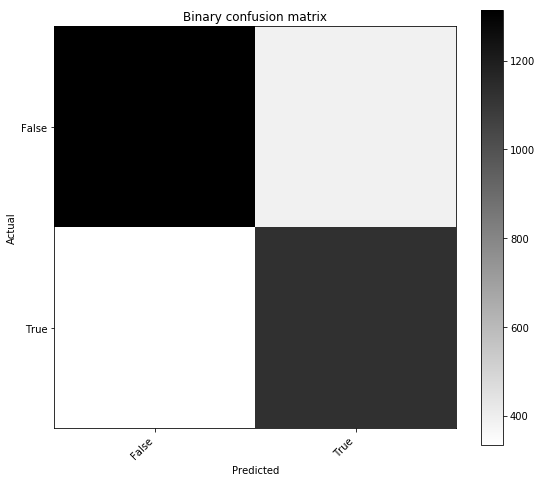

In [31]:
%matplotlib inline
# Confusion Matrix

confusion_matrix = ConfusionMatrix(y_test, rounded_predictions)
print("Confusion matrix:\n%s" % confusion_matrix)
confusion_matrix.plot()

In [32]:
# ROC AUC
print('ROC AUC: ', roc_auc_score(y_test, predictions))

ROC AUC:  0.8399941113988556


### 4. Examine the predictions
Let's look at the predictions the NN gets wrong, see if there's a pattern

In [33]:
# Create df with the relevant data
test_set = df1.loc[test_rows]
test_set['Predictions'] = predictions
test_set['RoundPredictions'] = rounded_predictions

In [34]:
# Optimise memory --> set col types for the incoming CSV
cds_cols = ['# ChemicalName', 'ChemicalID', 'DiseaseName', 'DiseaseID', 'DirectEvidence']
cd_col_types = {   
    '# ChemicalName': 'category',
    'ChemicalID': 'category',
    'DiseaseName': 'category',
    'DiseaseID': 'category',
}

In [35]:
# Let's get the disease and chemical names back! For the sake of eyeballing for patterns
# Read in CTD csv, skipping the intro rows
df_cd = pd.read_csv('../ctd-to-nt/csvs/CTD_chemicals_diseases.csv', usecols=cds_cols, dtype=cd_col_types, skiprows=27)
df_cd = df_cd.drop(0)
df_cd = df_cd.dropna(subset=['DirectEvidence']) # drop if it doesn't have direct evidence

In [36]:
df_cd.head()

,# ChemicalName,ChemicalID,DiseaseName,DiseaseID,DirectEvidence
1,06-Paris-LA-66 protocol,C046983,Precursor Cell Lymphoblastic Leukemia-Lymphoma,MESH:D054198,therapeutic
71,"10,10-bis(4-pyridinylmethyl)-9(10H)-anthracenone",C112297,Hyperkinesis,MESH:D006948,marker/mechanism
86,"10,10-bis(4-pyridinylmethyl)-9(10H)-anthracenone",C112297,Seizures,MESH:D012640,marker/mechanism
135,"10,11-dihydro-10-hydroxycarbamazepine",C039775,Epilepsy,MESH:D004827,therapeutic
189,"10,11-dihydroxy-N-n-propylnorapomorphine",C425777,Hyperkinesis,MESH:D006948,marker/mechanism


In [37]:
test_set.head()

,index,ChemicalID,DiseaseID,DVec,CVec,Correlation,train,test,val,Predictions,RoundPredictions
106,107,D016604,MESH:D006528,"[-0.08886489, 0.05181756, -0.07574534, -0.0861...","[-0.00354247144, 0.12560007, 0.0581751503, -0....",1,False,True,False,0.802016,1
107,108,D016604,MESH:D006529,"[-0.0443360731, 0.0929108113, -0.0618022271, -...","[-0.00354247144, 0.12560007, 0.0581751503, -0....",1,False,True,False,0.916537,1
108,109,D016604,MESH:D008114,"[-0.07485863, 0.03075173, -0.15932283, -0.0724...","[-0.00354247144, 0.12560007, 0.0581751503, -0....",1,False,True,False,0.848348,1
109,110,D016604,MESH:D056486,"[-0.09119818, 0.04336861, -0.22456889, -0.1367...","[-0.00354247144, 0.12560007, 0.0581751503, -0....",1,False,True,False,0.874072,1
110,111,D016604,MESH:D019457,"[-0.0169730633, 0.113205932, 0.0383857302, -0....","[-0.00354247144, 0.12560007, 0.0581751503, -0....",1,False,True,False,0.392937,0


In [38]:
# test_set.DiseaseID.nunique()

In [39]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

In [40]:
test_set['Correlation'] = test_set.Correlation.astype(np.uint8)
print(mem_usage(test_set['RoundPredictions']))
test_set['RoundPredictions'] = test_set.RoundPredictions.astype(np.uint8)
print(mem_usage(test_set['RoundPredictions']))

0.05 MB
0.03 MB


In [41]:
lst = [chem_dis, df, df_d, df_c, Dvecs, Cvecs]
del lst
test_set = test_set.drop(['DVec', 'CVec', 'index'], axis=1) # memory intensive
for col in ['DiseaseID', 'ChemicalID', 'DiseaseName', '# ChemicalName', 'DirectEvidence']:
    print(col,  df_cd.columns)
    if str(col) in df_cd.columns: print('sd') # df_cd[col] = df_cd[col].astype('category')
    if col in test_set.columns: test_set[col] = test_set[col].astype('category')

DiseaseID Index(['# ChemicalName', 'ChemicalID', 'DiseaseName', 'DiseaseID',
       'DirectEvidence'],
      dtype='object')
sd
ChemicalID Index(['# ChemicalName', 'ChemicalID', 'DiseaseName', 'DiseaseID',
       'DirectEvidence'],
      dtype='object')
sd
DiseaseName Index(['# ChemicalName', 'ChemicalID', 'DiseaseName', 'DiseaseID',
       'DirectEvidence'],
      dtype='object')
sd
# ChemicalName Index(['# ChemicalName', 'ChemicalID', 'DiseaseName', 'DiseaseID',
       'DirectEvidence'],
      dtype='object')
sd
DirectEvidence Index(['# ChemicalName', 'ChemicalID', 'DiseaseName', 'DiseaseID',
       'DirectEvidence'],
      dtype='object')
sd


In [42]:
mem_usage(df_cd)

'13.04 MB'

In [43]:
# merge in the names

# Because this weirdly requires a tonne of memory, let's optimise (for stupid terrible top-of-range dell laptop)
# lst = [chem_dis, df, df_d, df_c, Dvecs, Cvecs]
# del lst
# test_set = test_set.drop(['DVec', 'CVec', 'index'], axis=1) # memory intensive
# for col in ['DiseaseID', 'ChemicalID', 'DiseaseName', '# ChemicalName', 'DirectEvidence']:
#     if col in df_cd.columns: df_cd[col] = df_cd[col].astype('category')
#     if col in test_set.columns: test_set[col] = test_set[col].astype('category')

test_set = pd.merge(test_set, df_cd[['DiseaseID', 'DiseaseName']], on='DiseaseID')
test_set = pd.merge(test_set, df_cd[['# ChemicalName', 'ChemicalID']], on='ChemicalID')

# weirdly these operations introduce millions of duplicate rows, so delete duplicates:
test_set = test_set.drop_duplicates(list(set(test_set.columns.values))) #- set(['DVec','CVec'])))

In [44]:
df_cd.ChemicalID = df_cd.ChemicalID.astype('category')
type(df_cd.ChemicalID[1])

str

In [45]:
test_set[['DiseaseName', '# ChemicalName', 'Correlation', 'Predictions', 'RoundPredictions']].to_csv('predictions.csv', index=False)

In [46]:
test_set.head()

,ChemicalID,DiseaseID,Correlation,train,test,val,Predictions,RoundPredictions,DiseaseName,# ChemicalName
0,D016604,MESH:D006528,1,False,True,False,0.802016,1,"Carcinoma, Hepatocellular",Aflatoxin B1
5984,D016604,MESH:D006529,1,False,True,False,0.916537,1,Hepatomegaly,Aflatoxin B1
13904,D016604,MESH:D008114,1,False,True,False,0.848348,1,"Liver Neoplasms, Experimental",Aflatoxin B1
19910,D016604,MESH:D056486,1,False,True,False,0.874072,1,Chemical and Drug Induced Liver Injury,Aflatoxin B1
48334,D016604,MESH:D019457,1,False,True,False,0.392937,0,Chromosome Breakage,Aflatoxin B1


In [47]:
# Import gofunction counts (for each disease and each chem). This csv was output in opa2vec.ipynb
gofunc_counts = pd.read_csv('gofunc_counts.csv')
test_set = pd.merge(test_set, gofunc_counts[['ChemicalID', 'gofunc']], on='ChemicalID')
test_set = test_set.rename(columns = {'gofunc':'ChemGoFuncs'})
test_set = pd.merge(test_set, gofunc_counts[['DiseaseID', 'gofunc']], on='DiseaseID')
test_set = test_set.rename(columns = {'gofunc':'DisGoFuncs'})

In [48]:
test_set.head()

,ChemicalID,DiseaseID,Correlation,train,test,val,Predictions,RoundPredictions,DiseaseName,# ChemicalName,ChemGoFuncs,DisGoFuncs
0,D016604,MESH:D006528,1,False,True,False,0.802016,1,"Carcinoma, Hepatocellular",Aflatoxin B1,32,252
1,D016604,MESH:D006528,1,False,True,False,0.802016,1,"Carcinoma, Hepatocellular",Aflatoxin B1,32,252
2,D016604,MESH:D006528,1,False,True,False,0.802016,1,"Carcinoma, Hepatocellular",Aflatoxin B1,32,252
3,D016604,MESH:D006528,1,False,True,False,0.802016,1,"Carcinoma, Hepatocellular",Aflatoxin B1,32,252
4,D016604,MESH:D006528,1,False,True,False,0.802016,1,"Carcinoma, Hepatocellular",Aflatoxin B1,32,252


In [49]:
# # This cell is pointless - manually verifying accuracy test
# # Round predictions to int based on threshold, run accuracy-test manually
# predictions = model.predict(X_test)
# threshold = predictions[:].sum()/len(predictions) # Threshold is the mean value of predictions
# predictions = [float(round(x[0]-threshold+0.5)) for x in predictions]
# manual_accuracy = sklearn.metrics.accuracy_score(y_test, predictions, normalize=True, sample_weight=None)
# print(manual_accuracy)

### 5. Calculate Cosine Similarity

In [50]:
# df1.head()

In [51]:
# # Calculate out the cosine similarity and see if there's a difference between groups
# def cosine_sim (row):
#     return cosine_similarity(np.array(row.DVec).reshape(1, -1), np.array(row.CVec).reshape(1, -1))[0][0]

# df1['cosine_sim'] = df1.apply(lambda row: cosine_sim(row), axis=1)

# # Compare cosine sim of correlated and uncorrelated groups
# print('Cosine mean with no correlation: ', df1[df1.Correlation == 1 ].cosine_sim.mean())
# print('Cosine mean with correlation: ', df1[df1.Correlation == 0 ].cosine_sim.mean())

### 6. Save Model

In [52]:
# # Save model (in two files, one for weights and one for json)
# json_string = model.to_json()
# model.save_weights("model2-0.82.h5")
# with open('model2-0.82.json', 'w') as outfile:
#     json.dump(json_string, outfile)